In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle
import matplotlib.pyplot as plt
import cvxpy

pd.options.mode.chained_assignment = None

In [2]:
def XOX(s, p):
    '''
    将绝对量数据转化为增长率 ( e.g. [1,2,3] -> [2,1.5,NA] )
    s : array
    p : look-back period
    '''
    return np.append((s[p:] - s[:-p])/s[:-p], np.repeat(np.nan, p))

def lagging(s, l):
    '''
    向前平移时间序列 ( e.g. [1,2,3] -> [2,3,NA] )
    s : array
    l : lagging period
    '''
    return np.append(s[l:], np.repeat(np.nan, l))

In [3]:
data = pd.read_csv('CONTEST_DATA_TEST_100_1.csv', header = None) \
    .append(pd.read_csv('data900-999.csv', header = None)).reset_index(drop = True)
data.rename(columns={0:'day', 
                     1:'stock', 
                     2:'open', 
                     3:'high', 
                     4:'low', 
                     5:'close', 
                     6:'volume', 
                     7:'moneyvolume'}, inplace=True)
data['close_chg_10'] = data[['stock', 'close']].groupby('stock').transform(lambda x: lagging(XOX(x.values, 10), 1))

In [4]:
data

,day,stock,open,high,low,close,volume,moneyvolume,8,9,...,99,100,101,102,103,104,105,106,107,close_chg_10
0,0.0,6000.0,60.90,61.17,59.57,59.70,2756306.0,1.659607e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008664
1,0.0,6001.0,16.13,16.21,16.04,16.13,2120886.0,3.421016e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007817
2,0.0,6002.0,138.29,138.81,134.84,135.53,4376392.0,5.935791e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005265
3,0.0,6003.0,28.51,28.90,28.47,28.71,400276.0,1.144611e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042903
4,0.0,6004.0,33.40,34.64,33.40,34.19,799353.0,2.715962e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,999.0,6495.0,19.50,19.79,19.44,19.47,1735455.0,3.412445e+07,0.231079,-0.288574,...,-0.710449,0.066162,-0.609375,-0.656738,-0.511719,0.488525,-0.243652,0.132324,0.470703,NaN
499996,999.0,6496.0,215.02,217.61,204.35,206.94,2360347.0,4.964025e+08,-0.670898,-1.409180,...,-0.710449,1.028320,-0.451172,-1.633789,-0.049194,-0.439697,0.124634,0.113281,0.969727,NaN
499997,999.0,6497.0,279.49,279.85,273.82,274.17,4349590.0,1.205561e+09,-0.274414,-0.496094,...,-0.710449,1.617188,-0.798828,0.314697,-0.207275,0.056641,-0.185913,0.075134,0.631348,NaN
499998,999.0,6498.0,4.54,4.54,4.29,4.50,9437928.0,4.267815e+07,1.121094,3.000000,...,0.510254,-0.657715,-0.229980,1.068359,0.770020,-0.505371,3.000000,0.073486,0.157349,NaN


In [5]:
# 一个问题：数据特征并不随时间均匀分布。故先乱序。

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

data_shuf = shuffle(data, random_state = 2021)

y_train = data_shuf[(data['day'] < 500).values].dropna().close_chg_10.values
X_train = data_shuf[(data['day'] < 500).values].dropna().iloc[:,8:108].values
y_validate = data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().close_chg_10.values
X_validate = data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().iloc[:,8:108].values
y_test = data_shuf[(data['day'] >= 800).values].dropna().close_chg_10.values
X_test = data_shuf[(data['day'] >= 800).values].dropna().iloc[:,8:108].values

In [6]:
# # feature engineering ?

# min_20 = 0
# n = 0
# all_num = []
# for i in range(100):
#     all_num.append(abs(np.corrcoef(X_train[:,i], y_train)[0][1]))
# ind = []
# for i in range(100):
#     if abs(np.corrcoef(X_train[:,i], y_train)[0][1]) < 0.008226:
#         ind.append(i)
# ind = np.array(ind) + 8
# fdata = data.copy()
# fdata.drop(ind, axis=1, inplace = True)
# fdata_shuf = shuffle(fdata, random_state = 2021)

# y_train = fdata_shuf[(data['day'] < 500).values].dropna().close_chg_10.values
# X_train = fdata_shuf[(data['day'] < 500).values].dropna().iloc[:,8:88].values
# y_validate = fdata_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().close_chg_10.values
# X_validate = fdata_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().iloc[:,8:88].values
# y_test = fdata_shuf[(data['day'] >= 800).values].dropna().close_chg_10.values
# X_test = fdata_shuf[(data['day'] >= 800).values].dropna().iloc[:,8:88].values

In [7]:
def to_pm(s):
    '''
    提取序列中的正负号 ( e.g. [-3, 2, -2, 3] -> [-1, 1, -1, 1] )
    s : array
    '''
    s_pm = np.zeros(s.shape)
    for i in range(len(s)):
        if s[i] > 0:
            s_pm[i] = 1
        if s[i] < 0:
            s_pm[i] = -1
    return s_pm
def calc_accuracy(pred, real):
    return (1 + np.sum(to_pm(pred) * to_pm(real))/len(pred))/2

# linear model

In [8]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train);

# pickle.dump(lm, open('Model/linear_model.sav', 'wb'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


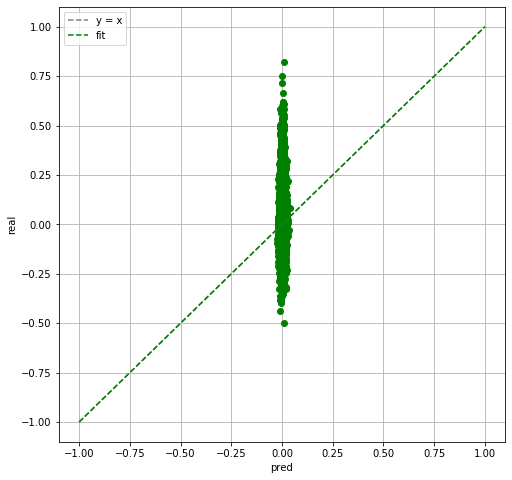

0.004260395945431408

In [9]:
y_train_pred = lm.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

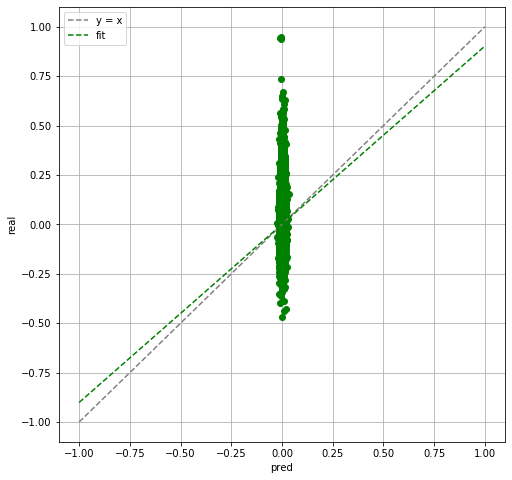

0.004326442288022535

In [10]:
y_validate_pred = lm.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

# l2 linear model

In [11]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train);

# pickle.dump(lm, open('Model/l2_linear_model.sav', 'wb'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


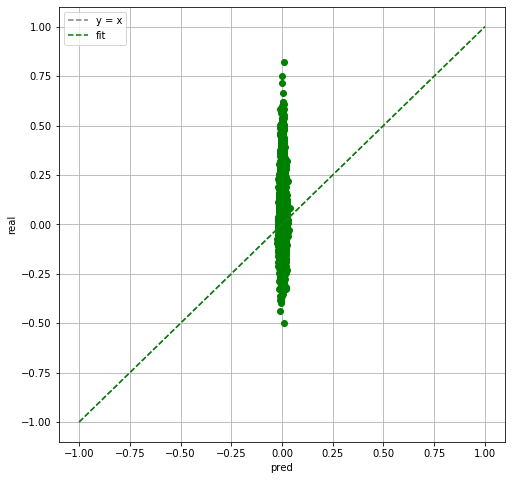

0.0042603959454722805

In [12]:
y_train_pred = ridge.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

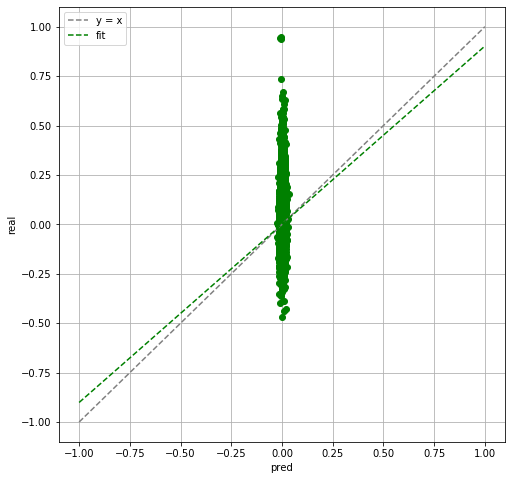

0.004326442062218633

In [13]:
y_validate_pred = ridge.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

# MLP

In [14]:
from sklearn.neural_network import MLPRegressor

hidden_layer_sizes = (80, 60, 40)
max_iter = 1000
alpha = 0.0001
learning_rate_init = 0.001

nnr = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, 
                   max_iter = max_iter, 
                   alpha = alpha, 
                   learning_rate_init = learning_rate_init, 
                   random_state = 2021)

nnr.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(80, 60, 40), max_iter=1000, random_state=2021)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


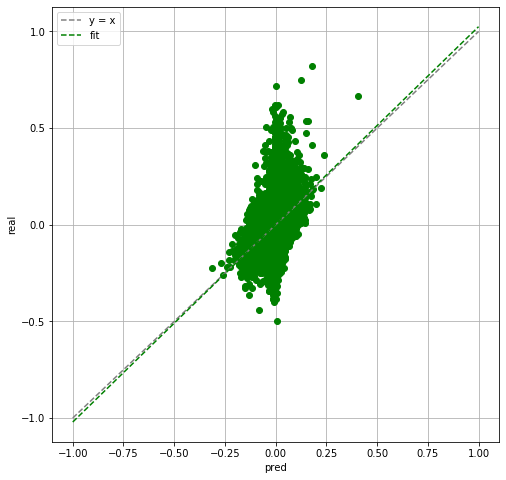

(0.004042897100123356, 0.542738171316707)

In [15]:
y_train_pred = nnr.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train), calc_accuracy(y_train_pred, y_train)

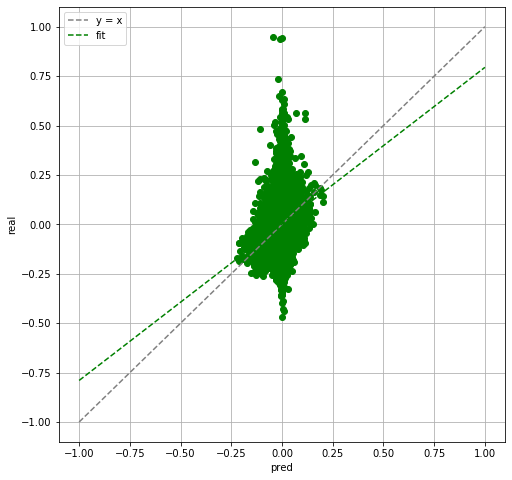

(0.0042150481908733795, 0.5334317313330234)

In [16]:
y_validate_pred = nnr.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate), calc_accuracy(y_validate_pred, y_validate)

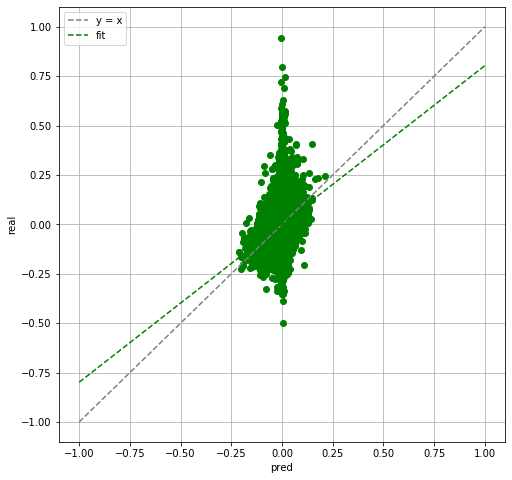

(0.00425897676560314, 0.5349395762754715)

In [17]:
y_test_pred = nnr.predict(X_test)

plt.figure(figsize=(8, 8))
plt.plot(y_test_pred, y_test, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_test_pred, y_test, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_test_pred, y_test), calc_accuracy(y_test_pred, y_test)

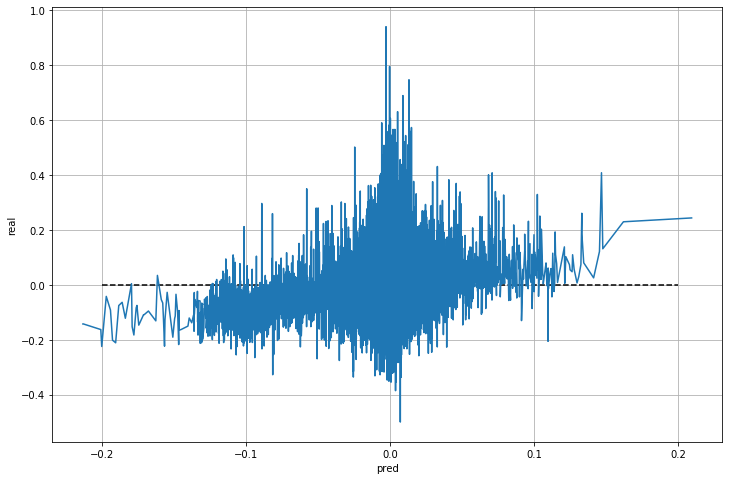

In [18]:
plt.figure(figsize=(12, 8))

plt.plot(y_test_pred[np.argsort(y_test_pred)], y_test[np.argsort(y_test_pred)])
plt.hlines(0, -0.2, 0.2, ls = '--')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.show()

## @ 元元：训练模型code在此

In [19]:
# 训练初始模型

y = data.dropna().close_chg_10.values
X = data.dropna().iloc[:,8:108].values

nnr_trade = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, 
                         max_iter = max_iter, 
                         alpha = alpha, 
                         learning_rate_init = learning_rate_init, 
                         random_state = 2021)

nnr_trade.fit(X, y)

pickle.dump(lm, open('Model/MLP_model_2.sav', 'wb'))

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

n_trees = 1

rfr = RandomForestRegressor(n_estimators = n_trees, random_state = 2021)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1, random_state=2021)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


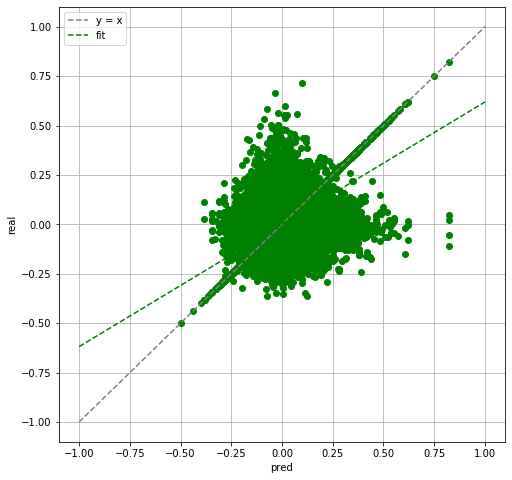

(0.003213041084702383, 0.8148524903129778)

In [21]:
y_train_pred = rfr.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train), calc_accuracy(y_train_pred, y_train)

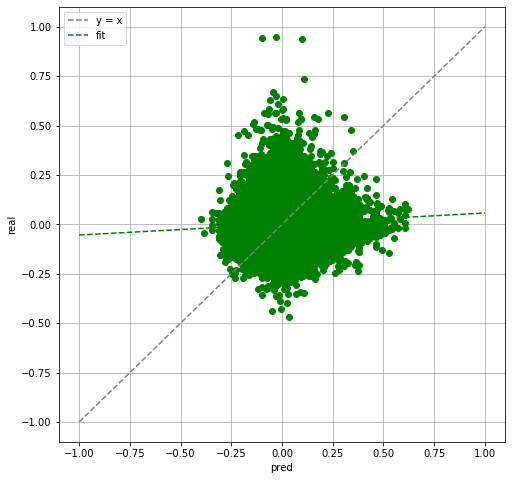

(0.008678837988086384, 0.5194774122674)

In [22]:
y_validate_pred = rfr.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate), calc_accuracy(y_validate_pred, y_validate)

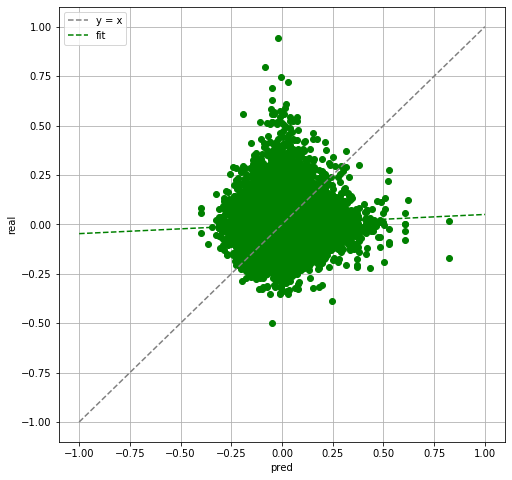

(0.008772034254093137, 0.5189361379380087)

In [23]:
y_test_pred = rfr.predict(X_test)

plt.figure(figsize=(8, 8))
plt.plot(y_test_pred, y_test, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_test_pred, y_test, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_test_pred, y_test), calc_accuracy(y_test_pred, y_test)

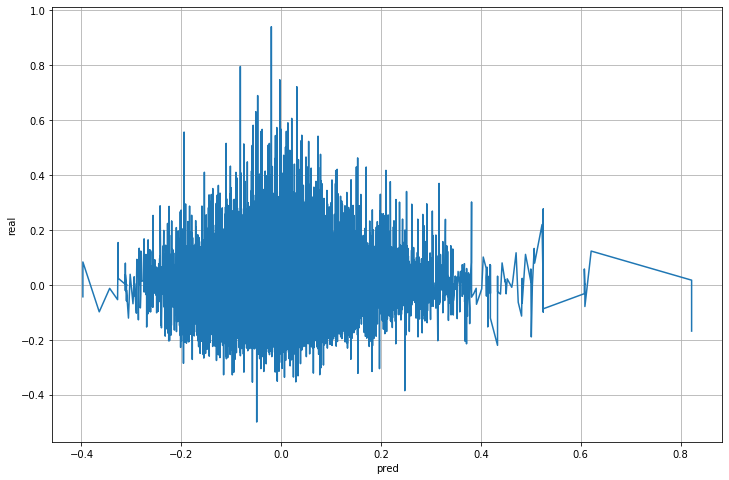

In [24]:
plt.figure(figsize=(12, 8))

plt.plot(y_test_pred[np.argsort(y_test_pred)], y_test[np.argsort(y_test_pred)])
plt.hlines(0, -0.2, 0.2, ls = '--')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.show()

# AdaBoost

In [25]:
from sklearn.ensemble import AdaBoostRegressor

n_boost = 10

abr = AdaBoostRegressor(n_estimators = n_boost, random_state = 2021)
abr.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=10, random_state=2021)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


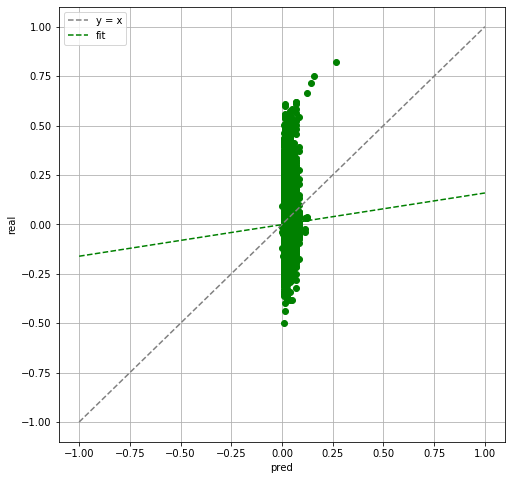

(0.004540439898535209, 0.5016886562745209)

In [26]:
y_train_pred = abr.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train), calc_accuracy(y_train_pred, y_train)

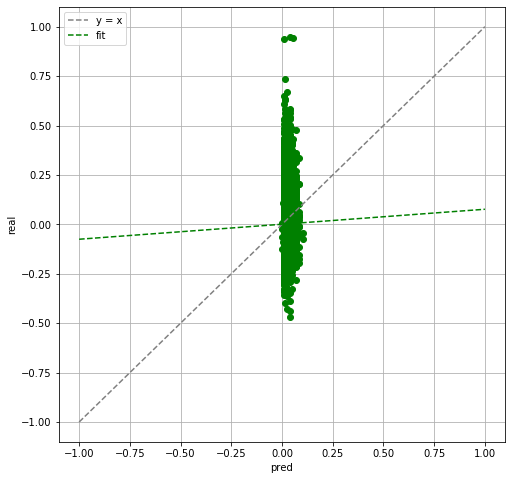

(0.004600777443636877, 0.50292161184011)

In [27]:
y_validate_pred = abr.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate), calc_accuracy(y_validate_pred, y_validate)

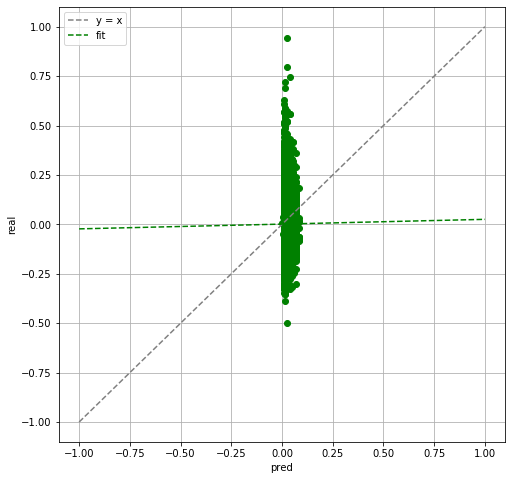

(0.004660401582657006, 0.5035293522778985)

In [28]:
y_test_pred = abr.predict(X_test)

plt.figure(figsize=(8, 8))
plt.plot(y_test_pred, y_test, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_test_pred, y_test, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_test_pred, y_test), calc_accuracy(y_test_pred, y_test)

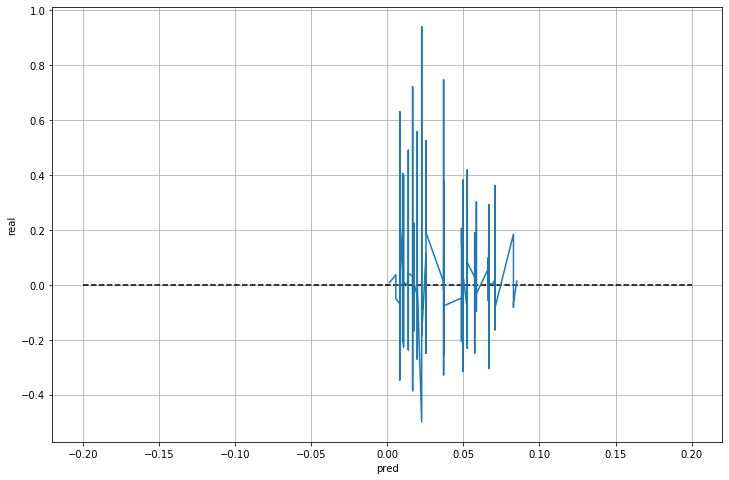

In [29]:
plt.figure(figsize=(12, 8))

plt.plot(y_test_pred[np.argsort(y_test_pred)], y_test[np.argsort(y_test_pred)])
plt.hlines(0, -0.2, 0.2, ls = '--')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.show()

# LightGBM

In [30]:
# # 每天的新data

# daily = pd.DataFrame(np.random.rand(500, 108))
# daily.rename(columns={0:'day', 
#                      1:'stock', 
#                      2:'open',
#                      3:'high', 
#                      4:'low',
#                      5:'close', 
#                      6:'volume', 
#                      7:'moneyvolume'}, inplace=True)
# X_pred = daily.iloc[:,8:108].values

# pred = lm.predict(X_pred)

# longstock = pred.argsort()[-25:] # array中的位置
# shortstock = pred.argsort()[:25] # array中的位置

# capital = 5e8
# leverage = 1.5

# new_pos = pd.DataFrame(np.zeros([10, 500]))